# Imagenet - Normalization Image

|S.No.|Optimization|Architecture|Pretrained|Pre-processing|Batch Count|Epochs|Loss Function|Optimizer|LR|Scheduler|Time per epoch|Test Acc|Val Acc|Overfitting| Underfitting|
|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|
|1|Basic|Resnet50|No|Convert To Tensor|128|30|CrossEntropyLoss|SGD|None|0.05|1.30|99.84|68.33|Yes|No|
|2|Resize Image|Resnet50|No|Resize Image|128|30|CrossEntropyLoss|SGD|None|0.05|1.30|99.86|69.89|Yes|No|
|3|Normalized Image|Resnet50|No|Normalized Image|128|30|CrossEntropyLoss|SGD|None|0.05|1.30|99.89|70.34|Yes|No|

## Summary
- Slight improvement in the accuracy
- Still model is overfitting
- Zig zag pattern in Validation Accuracy
- Crossed 70% val accuracy in last epoch

## Install Packages

In [1]:
!pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu118 # Install packages in the correct order
!pip install numpy==1.24.3
!pip install tqdm matplotlib pillow
!pip install seaborn scikit-learn

Looking in indexes: https://download.pytorch.org/whl/cu118


## Check for CUDA and set device

In [2]:
# Verify CUDA availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch version: 2.4.1+cu118
CUDA available: True
CUDA device: Tesla T4
Using device: cuda


## Import all packages

In [3]:
# Import all required libraries
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import urllib.request
import zipfile
import shutil

## Verify installation and important package versions

In [4]:
# Verify installations
import numpy as np
print(f"Numpy version: {np.__version__}")

import torch
print(f"PyTorch version: {torch.__version__}")

import torchvision
print(f"Torchvision version: {torchvision.__version__}")

Numpy version: 1.24.3
PyTorch version: 2.4.1+cu118
Torchvision version: 0.19.1+cu118


In [5]:
## Application Constants
BATCH_SIZE = 128
NUM_CLASSES = 200
EPOCHS_COUNT = 30

## Download Dataset

In [6]:
# Download and extract Tiny ImageNet
def download_and_extract_tiny_imagenet():
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    zip_path = "tiny-imagenet-200.zip"
    extract_path = "tiny-imagenet-200"
    
    if not os.path.exists(extract_path):
        print("Downloading Tiny ImageNet...")
        urllib.request.urlretrieve(url, zip_path)
        
        print("Extracting files...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall("./")
        
        # Remove the zip file
        os.remove(zip_path)
        print("Dataset ready!")
    else:
        print("Dataset already exists!")
    
    return extract_path

In [7]:
# Prepare validation directory structure
def restructure_val_dir(dataset_path):
    val_dir = os.path.join(dataset_path, 'val')
    val_images_dir = os.path.join(val_dir, 'images')
    
    if os.path.exists(val_images_dir):
        # Read validation annotations file
        val_annotations_file = os.path.join(val_dir, 'val_annotations.txt')
        with open(val_annotations_file, 'r') as f:
            val_annotations = f.readlines()
        
        # Create class directories and move images
        for line in val_annotations:
            parts = line.strip().split('\t')
            img_name, class_id = parts[0], parts[1]
            
            # Create class directory if it doesn't exist
            class_dir = os.path.join(val_dir, class_id)
            os.makedirs(class_dir, exist_ok=True)
            
            # Move image to class directory
            src_path = os.path.join(val_images_dir, img_name)
            dst_path = os.path.join(class_dir, img_name)
            if os.path.exists(src_path):
                shutil.move(src_path, dst_path)
        
        # Remove the original images directory and annotations file
        shutil.rmtree(val_images_dir)
        os.remove(val_annotations_file)

In [8]:
# Download and prepare dataset
dataset_path = download_and_extract_tiny_imagenet()
restructure_val_dir(dataset_path)

Dataset already exists!


## Define Transformations

In [9]:
# Define data transforms
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Tiny ImageNet images are 64x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Prepare Dataset

In [10]:
# Load datasets
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')

train_dataset = ImageFolder(train_dir, transform=train_transform)
val_dataset = ImageFolder(val_dir, transform=val_transform)


In [11]:
# Create data loaders
batch_size = BATCH_SIZE  # Increased batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


## Load Resnet50 Model

In [12]:
# Load ResNet50 with pretrained=False for training from scratch
model = torchvision.models.resnet50(weights='ResNet50_Weights.DEFAULT')
num_classes = NUM_CLASSES
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


## Define Loss Function and Optimizer

In [13]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)

## Train the model

In [14]:
# Training function
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc='Training')
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


In [15]:
# Validation function
def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


In [16]:
# Training loop
num_epochs = EPOCHS_COUNT
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")



Epoch 1/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 22.93it/s]


Train Loss: 1.7002 | Train Acc: 60.03%
Val Loss: 1.2836 | Val Acc: 67.40%

Epoch 2/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 22.94it/s]


Train Loss: 0.8139 | Train Acc: 78.68%
Val Loss: 1.2615 | Val Acc: 69.00%

Epoch 3/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.94it/s]


Train Loss: 0.4344 | Train Acc: 88.35%
Val Loss: 1.3628 | Val Acc: 67.93%

Epoch 4/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.69it/s]


Train Loss: 0.2325 | Train Acc: 93.84%
Val Loss: 1.3812 | Val Acc: 69.32%

Epoch 5/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.62it/s]


Train Loss: 0.1232 | Train Acc: 96.87%
Val Loss: 1.4576 | Val Acc: 69.53%

Epoch 6/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.99it/s]


Train Loss: 0.0711 | Train Acc: 98.30%
Val Loss: 1.5499 | Val Acc: 68.92%

Epoch 7/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.70it/s]


Train Loss: 0.0432 | Train Acc: 99.06%
Val Loss: 1.5654 | Val Acc: 69.49%

Epoch 8/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.58it/s]


Train Loss: 0.0278 | Train Acc: 99.41%
Val Loss: 1.6138 | Val Acc: 69.81%

Epoch 9/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.75it/s]


Train Loss: 0.0228 | Train Acc: 99.53%
Val Loss: 1.6839 | Val Acc: 69.23%

Epoch 10/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.83it/s]


Train Loss: 0.0209 | Train Acc: 99.58%
Val Loss: 1.7716 | Val Acc: 68.34%

Epoch 11/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.47it/s]


Train Loss: 0.0190 | Train Acc: 99.59%
Val Loss: 1.7707 | Val Acc: 69.06%

Epoch 12/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.75it/s]


Train Loss: 0.0174 | Train Acc: 99.62%
Val Loss: 1.7475 | Val Acc: 69.36%

Epoch 13/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.62it/s]


Train Loss: 0.0153 | Train Acc: 99.67%
Val Loss: 1.9760 | Val Acc: 66.25%

Epoch 14/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.48it/s]


Train Loss: 0.0141 | Train Acc: 99.67%
Val Loss: 1.7593 | Val Acc: 70.00%

Epoch 15/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.82it/s]


Train Loss: 0.0115 | Train Acc: 99.74%
Val Loss: 1.7942 | Val Acc: 69.25%

Epoch 16/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.78it/s]


Train Loss: 0.0128 | Train Acc: 99.71%
Val Loss: 1.7811 | Val Acc: 70.00%

Epoch 17/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.83it/s]


Train Loss: 0.0103 | Train Acc: 99.77%
Val Loss: 1.8246 | Val Acc: 69.38%

Epoch 18/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.89it/s]


Train Loss: 0.0099 | Train Acc: 99.79%
Val Loss: 1.9680 | Val Acc: 68.23%

Epoch 19/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.68it/s]


Train Loss: 0.0107 | Train Acc: 99.75%
Val Loss: 1.8716 | Val Acc: 69.36%

Epoch 20/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.52it/s]


Train Loss: 0.0104 | Train Acc: 99.75%
Val Loss: 1.8638 | Val Acc: 69.30%

Epoch 21/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 24.00it/s]


Train Loss: 0.0096 | Train Acc: 99.77%
Val Loss: 1.8538 | Val Acc: 69.51%

Epoch 22/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.60it/s]


Train Loss: 0.0086 | Train Acc: 99.80%
Val Loss: 1.8493 | Val Acc: 69.53%

Epoch 23/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.74it/s]


Train Loss: 0.0077 | Train Acc: 99.80%
Val Loss: 1.8594 | Val Acc: 70.10%

Epoch 24/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.68it/s]


Train Loss: 0.0061 | Train Acc: 99.86%
Val Loss: 1.8891 | Val Acc: 69.79%

Epoch 25/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.71it/s]


Train Loss: 0.0059 | Train Acc: 99.85%
Val Loss: 1.8719 | Val Acc: 70.04%

Epoch 26/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 24.03it/s]


Train Loss: 0.0066 | Train Acc: 99.83%
Val Loss: 1.8856 | Val Acc: 70.30%

Epoch 27/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.82it/s]


Train Loss: 0.0055 | Train Acc: 99.88%
Val Loss: 1.9191 | Val Acc: 69.33%

Epoch 28/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.72it/s]


Train Loss: 0.0063 | Train Acc: 99.85%
Val Loss: 1.9562 | Val Acc: 69.47%

Epoch 29/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.98it/s]


Train Loss: 0.0062 | Train Acc: 99.85%
Val Loss: 1.9473 | Val Acc: 69.31%

Epoch 30/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.93it/s]

Train Loss: 0.0047 | Train Acc: 99.89%
Val Loss: 1.9031 | Val Acc: 70.34%


## Plot Metrics

In [17]:
# Plot training and validation metrics
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

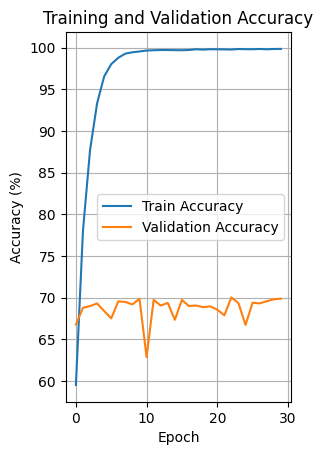

In [18]:
# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

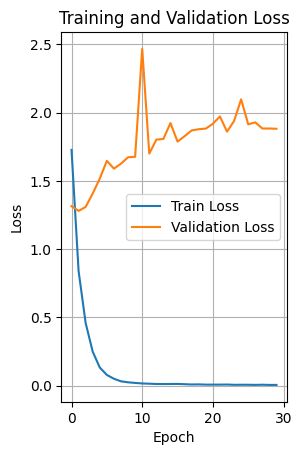

In [19]:
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

In [20]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

## Save Model

In [21]:
# Save the model
torch.save(model.state_dict(), 'resnet50_tiny_imagenet.pth')

## Plot Misclassified Images

In [22]:
def get_class_name_mapping(dataset_path):
    """
    Create mapping from wnid to human-readable class names using words.txt
    """
    words_file = os.path.join(dataset_path, 'words.txt')
    wnid_to_name = {}
    
    try:
        with open(words_file, 'r') as f:
            for line in f:
                wnid, names = line.strip().split('\t')
                # Take the first comma-separated name if multiple exist
                name = names.split(',')[0].strip()
                wnid_to_name[wnid] = name
    except FileNotFoundError:
        print(f"Warning: words.txt not found at {words_file}")
        # Create a simple mapping if words.txt is not available
        wnid_to_name = {class_id: class_id for class_id in train_dataset.classes}
    
    return wnid_to_name

In [23]:
def denormalize(tensor):
    """
    Denormalize the image tensor for visualization
    """
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

In [24]:
def get_misclassified_images(model, val_loader, class_mapping, num_images=20):
    """
    Get misclassified images with their true and predicted labels
    """
    model.eval()
    misclassified_images = []
    true_classes = []
    pred_classes = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            # Find misclassified images
            mask = (predicted != labels)
            misclassified_idx = mask.nonzero(as_tuple=True)[0]
            
            for idx in misclassified_idx:
                if len(misclassified_images) >= num_images:
                    break
                
                # Get wnids
                true_wnid = train_dataset.classes[labels[idx].item()]
                pred_wnid = train_dataset.classes[predicted[idx].item()]
                
                # Get human-readable names
                true_class_name = class_mapping.get(true_wnid, true_wnid)
                pred_class_name = class_mapping.get(pred_wnid, pred_wnid)
                
                misclassified_images.append(images[idx].cpu())
                true_classes.append(true_class_name)
                pred_classes.append(pred_class_name)
                
            if len(misclassified_images) >= num_images:
                break
    
    return misclassified_images, true_classes, pred_classes

In [25]:
def plot_misclassified(images, true_classes, pred_classes, num_images=20):
    """
    Plot misclassified images in a grid
    """
    if len(images) < num_images:
        num_images = len(images)
    
    num_rows = (num_images + 4) // 5  # 5 images per row
    fig, axes = plt.subplots(num_rows, 5, figsize=(20, 4*num_rows))
    axes = axes.ravel()
    
    for idx in range(num_images):
        # img = denormalize(images[idx])
        img = images[idx]
        img = torch.clamp(img, 0, 1)
        
        # Format class names
        true_class = true_classes[idx]
        pred_class = pred_classes[idx]
        
        # Truncate long class names
        true_display = true_class[:25] + '...' if len(true_class) > 25 else true_class
        pred_display = pred_class[:25] + '...' if len(pred_class) > 25 else pred_class
        
        axes[idx].imshow(img.permute(1, 2, 0))
        axes[idx].axis('off')
        title = f'True: {true_display}\nPred: {pred_display}'
        axes[idx].set_title(title, fontsize=10, color='red', pad=10)
    
    # Turn off any unused subplots
    for idx in range(num_images, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

In [26]:
# Get class name mapping
class_mapping = get_class_name_mapping(dataset_path)

In [27]:
# Get misclassified images
misclassified_images, true_classes, pred_classes = get_misclassified_images(
    model, val_loader, class_mapping
)

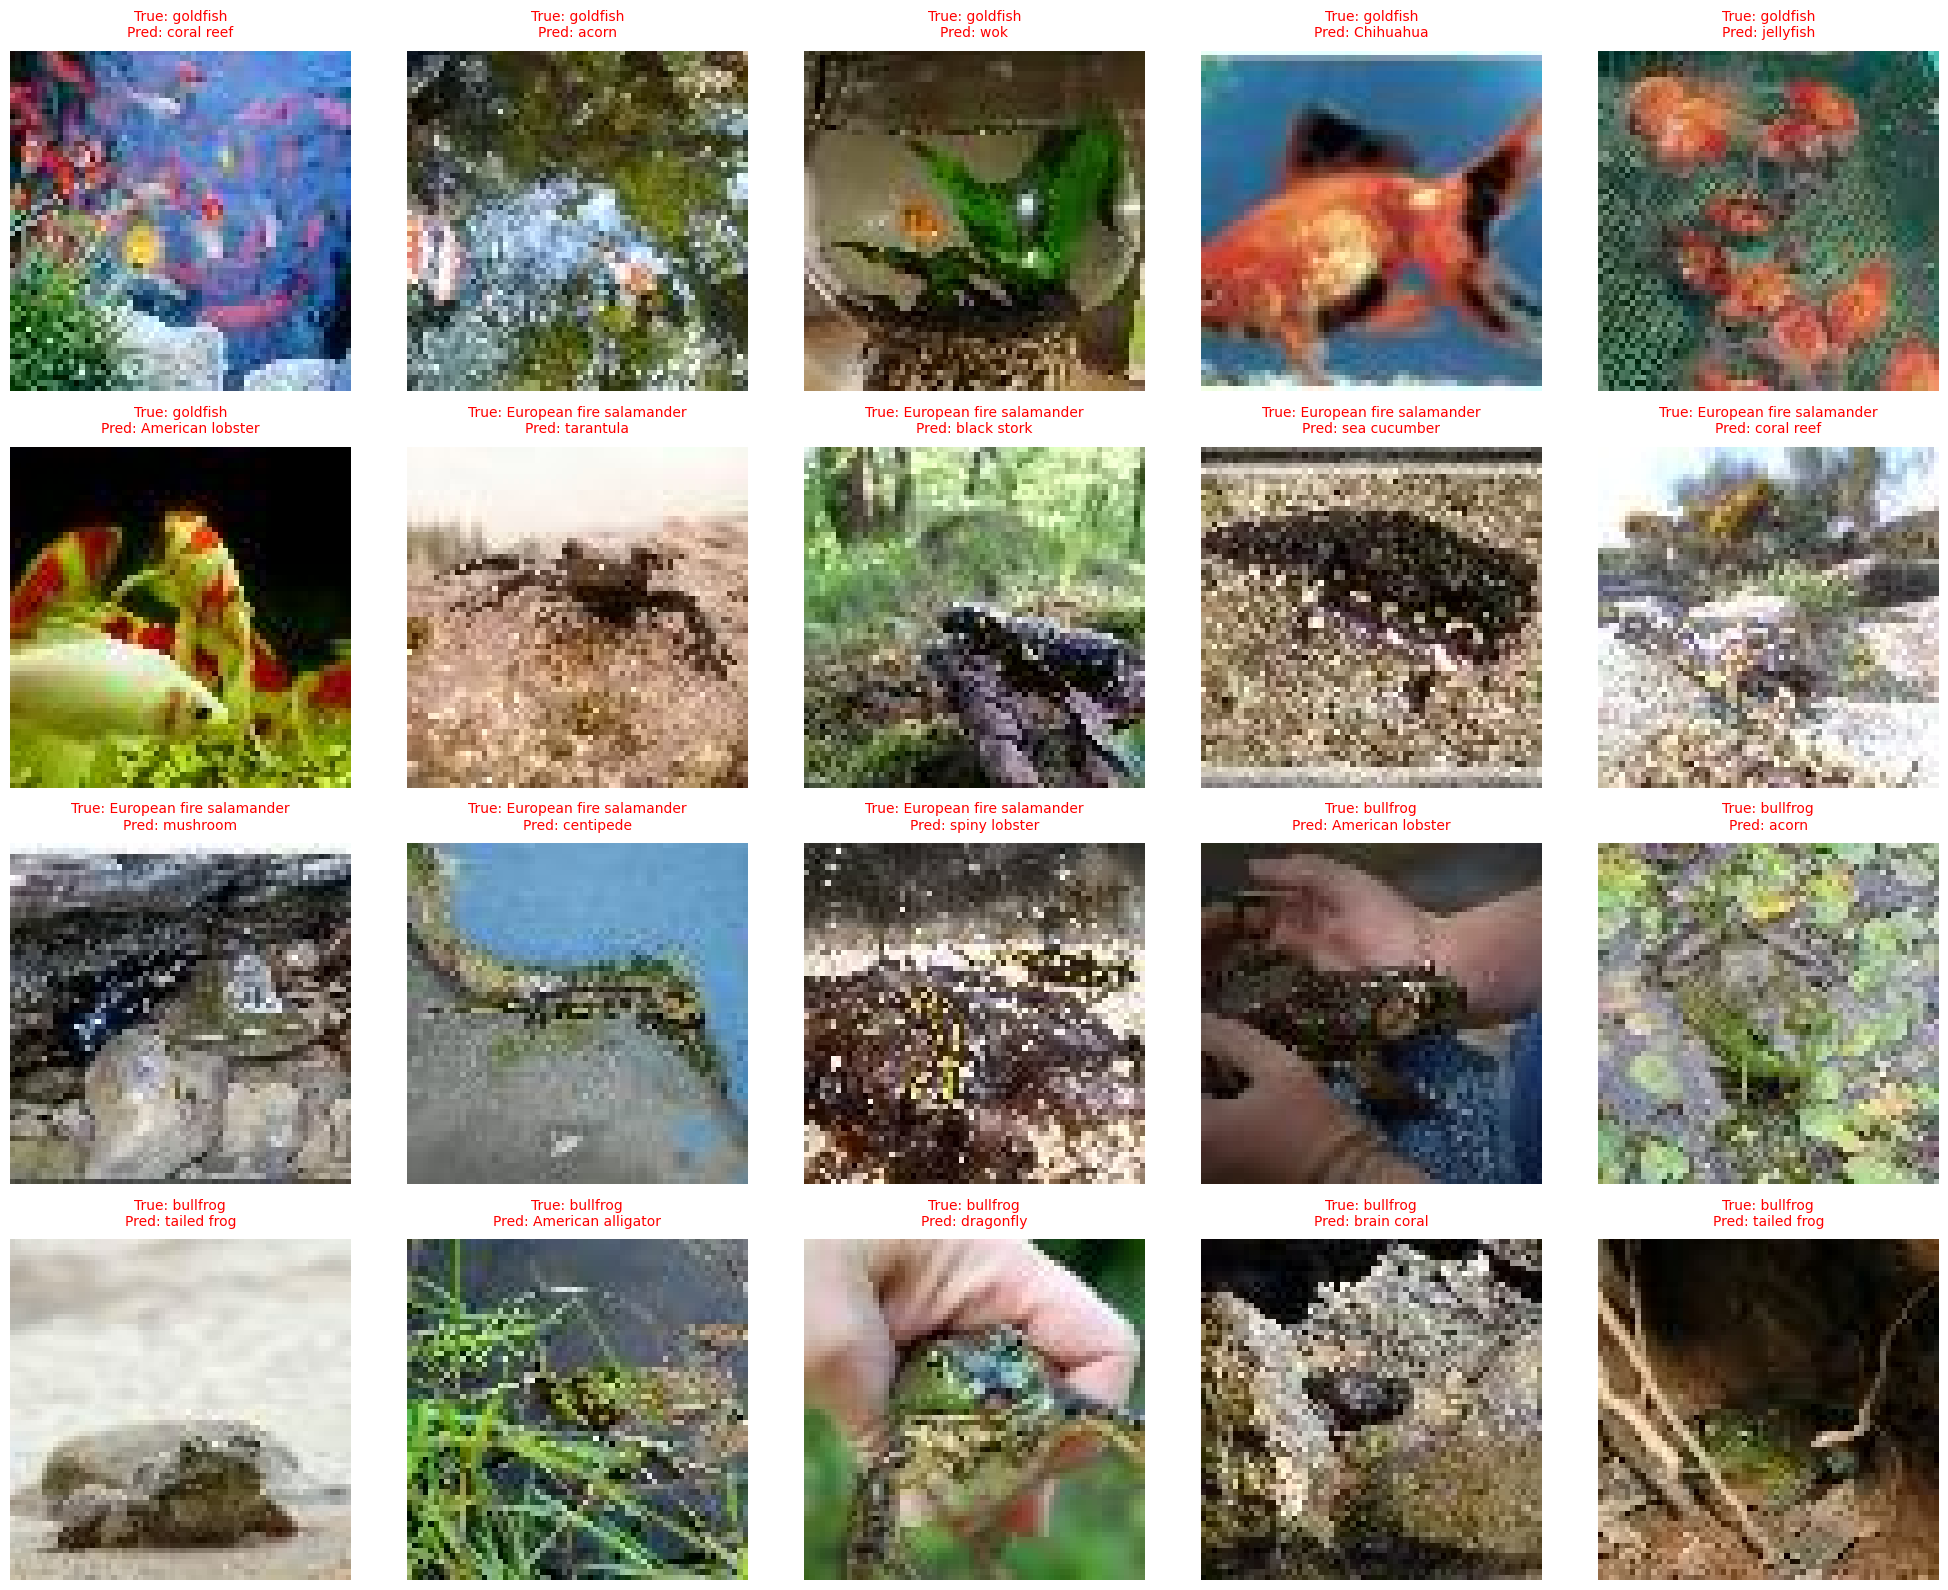

In [28]:
# Plot misclassified images
plot_misclassified(misclassified_images, true_classes, pred_classes)

In [29]:
# Print model accuracy
print("\nEvaluating model on validation set...")
model.eval()
correct = 0
total = 0
class_correct = {}
class_total = {}

with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Per-class accuracy
        for label, pred in zip(labels, predicted):
            label_name = class_mapping[train_dataset.classes[label.item()]]
            if label_name not in class_total:
                class_total[label_name] = 0
                class_correct[label_name] = 0
            class_total[label_name] += 1
            if label == pred:
                class_correct[label_name] += 1
                
# Overall accuracy
accuracy = 100 * correct / total
print(f"\nOverall Model Accuracy: {accuracy:.2f}%")

# Print per-class accuracy
print("\nPer-class Accuracy:")
accuracies = []
for class_name in class_total:
    class_acc = 100 * class_correct[class_name] / class_total[class_name]
    accuracies.append((class_name, class_acc))

# Sort by accuracy
accuracies.sort(key=lambda x: x[1], reverse=True)

# Print top 10 and bottom 10 classes
print("\nTop 10 Best Performing Classes:")
for class_name, acc in accuracies[:10]:
    print(f"{class_name[:40]:<40}: {acc:.2f}%")

print("\nBottom 10 Worst Performing Classes:")
for class_name, acc in accuracies[-10:]:
    print(f"{class_name[:40]:<40}: {acc:.2f}%")

# Analyze misclassifications
print("\nMost Common Misclassifications:")
misclass_count = {}
for true_class, pred_class in zip(true_classes, pred_classes):
    if true_class not in misclass_count:
        misclass_count[true_class] = {}
    if pred_class not in misclass_count[true_class]:
        misclass_count[true_class][pred_class] = 0
    misclass_count[true_class][pred_class] += 1

for true_class in misclass_count:
    print(f"\nTrue class: {true_class}")
    sorted_misclass = sorted(misclass_count[true_class].items(), 
                            key=lambda x: x[1], 
                            reverse=True)
    for pred_class, count in sorted_misclass[:3]:
        print(f"  Predicted as {pred_class}: {count} times")


Evaluating model on validation set...


100%|██████████| 79/79 [00:03<00:00, 21.46it/s]


Overall Model Accuracy: 69.89%

Per-class Accuracy:

Top 10 Best Performing Classes:
dugong                                  : 96.00%
gazelle                                 : 94.00%
trilobite                               : 92.00%
black widow                             : 92.00%
obelisk                                 : 92.00%
school bus                              : 92.00%
brain coral                             : 90.00%
Yorkshire terrier                       : 90.00%
lesser panda                            : 90.00%
gondola                                 : 90.00%

Bottom 10 Worst Performing Classes:
gasmask                                 : 50.00%
Labrador retriever                      : 48.00%
water jug                               : 48.00%
wooden spoon                            : 48.00%
pop bottle                              : 46.00%
syringe                                 : 46.00%
umbrella                                : 46.00%
plate                                   : 44

# ChapGPT

What you're describing suggests that your model is overfitting to the training data, which is a common issue in deep learning when training on small datasets. Here's a breakdown of what might be happening:

1. Overfitting to the Training Data:
Rapid increase in training accuracy: This indicates that your model is learning the specific patterns in the training set very well, including potentially noise or small details that don't generalize to new data.
Slow increase in validation accuracy: Since the validation data is different from the training data, your model is struggling to generalize to it. This discrepancy is a sign of overfitting.
2. Possible Causes:
Small Dataset (ImageNet Tiny): If the dataset is small (as is the case with ImageNet Tiny), there is a limited amount of data for the model to learn from. Deep networks like ResNet50, with millions of parameters, can easily overfit when the training data is not diverse or large enough to cover the complexity of the task.
Lack of Regularization: Without techniques like dropout, weight decay, or data augmentation, the model can memorize the training set rather than learning more generalizable patterns.
Learning Rate: If the learning rate is too high, it can lead to unstable training and overfitting as the model quickly adjusts to the training data without finding a proper solution that generalizes well.
3. What You Can Do:
Regularization: Implement techniques like dropout, L2 regularization (weight decay), or early stopping to prevent overfitting.
Data Augmentation: Augment your training data by applying transformations like rotations, flipping, scaling, and color changes to introduce more variety and help the model generalize better.
Reduce Model Complexity: If the model is too complex for the small dataset, consider using a smaller model or reducing the depth of the ResNet.
Learning Rate Tuning: Experiment with lower learning rates or use learning rate schedules (such as learning rate annealing) to allow the model to converge more slowly and avoid overfitting.
Cross-validation: Ensure you're evaluating your model on multiple validation subsets or using cross-validation techniques to get a more robust estimate of performance.
By addressing overfitting, the gap between your training and validation accuracies should decrease, leading to better generalization on unseen data.

A zig-zag pattern in the training accuracy and loss curves typically indicates that the model is facing some form of instability during training. This could be due to a few reasons, and here’s a breakdown of the possible causes and solutions:

Possible Causes for Zig-Zag Pattern:
Learning Rate Too High:

What it means: If the learning rate is too high, the model updates its weights too aggressively during each iteration. This causes the weights to oscillate around the optimal point, rather than steadily converging.
Result: You’ll see fluctuating training accuracy and loss values instead of a smooth downward trend in loss and upward trend in accuracy.
Gradient Instability / Exploding Gradients:

What it means: The gradients during backpropagation might be too large, causing the model’s weights to update too drastically. This is more common in very deep networks like ResNet50.
Result: Similar to the high learning rate issue, large updates to the weights can lead to erratic changes in the loss and accuracy during training.
Inconsistent Data or Label Noise:

What it means: If there are mislabeled images or noise in the dataset, the model may struggle to find clear patterns, resulting in unstable behavior.
Result: The model may alternate between fitting to different aspects of the data, causing a zig-zag in the loss and accuracy.
How to Overcome the Zig-Zag Pattern:
1. Lower the Learning Rate:
Solution: Try lowering the learning rate. A lower learning rate can help make smaller, more controlled updates to the model’s parameters, leading to smoother convergence.
How to do it: If you’re using a constant learning rate, try reducing it by a factor of 10 (e.g., from 0.01 to 0.001). Alternatively, use a learning rate scheduler like learning rate decay or reduce the learning rate when the loss plateaus.
2. Gradient Clipping:
Solution: If you're facing issues with exploding gradients, apply gradient clipping to limit the gradients' magnitude. This can help prevent the gradients from becoming too large and causing instability.
How to do it: Many deep learning frameworks (e.g., TensorFlow, PyTorch) allow you to clip gradients during training by specifying a maximum value or norm for the gradients.
3. Use a Smoother Optimizer:
Solution: Switch to a more advanced optimizer like Adam, RMSprop, or AdaGrad. These optimizers automatically adjust the learning rate for each parameter and often lead to more stable convergence.
How to do it: If you're currently using SGD (Stochastic Gradient Descent), try Adam, which is a more adaptive optimizer and often helps with stability.
4. Early Stopping / Checkpoints:
Solution: Implement early stopping to prevent overtraining when instability is observed. If the validation loss doesn’t improve after a certain number of epochs, stop training and restore the best model.
How to do it: Set a patience parameter (e.g., 10 epochs) for early stopping, so the model halts training if the validation loss hasn’t improved.
5. Batch Normalization:
Solution: If you haven’t already, add Batch Normalization layers to your model (ResNet50 might already have them). This normalizes the activations of each layer and helps stabilize the training process by reducing internal covariate shift.
How to do it: Check that Batch Normalization is included, or add it if necessary. Many modern architectures, including ResNet, use it by default.
6. Check Data Pipeline and Augmentation:
Solution: Inspect your data pipeline for inconsistencies. Ensure that your images are properly preprocessed (normalized to the same scale) and that any data augmentation strategies are not too aggressive (e.g., too large transformations that could confuse the model).
How to do it: Double-check your input pipeline, especially image resizing, normalization, and augmentation steps. If you use augmentation, make sure it’s reasonable for the dataset and task.
7. Use a Smaller Batch Size:
Solution: Sometimes, using a large batch size can lead to unstable training dynamics. Try reducing the batch size, which can help by introducing more noise into the gradient estimates, potentially leading to smoother updates.
How to do it: Experiment with smaller batch sizes (e.g., if you're using 64, try 32 or 16).
In Summary:
The zig-zag pattern is likely due to unstable updates caused by a high learning rate or exploding gradients. The solutions to this involve:

Reducing the learning rate
Using gradient clipping
Switching to more advanced optimizers like Adam
Ensuring proper data preprocessing
Using batch normalization
By applying these strategies, you should see more stable and smoother convergence during training, and your model will likely perform better on the validation set as well.